<span style="font-size: 200%;">Conjecture formulation in number theory via machine learning</span>

We will demonstrate how discoveries in number theory could have been automated with the use of machine learning. The point of these examples is to give the machine as little human input as possible. While we allow the data to be carefully selected by the mathematician, we require that the machine uncovers patterns in the data with minimal assistance. The entire notebook is self-contained, and all of the data we use can be generated on the spot, although certain cells may take up to an hour to run. The general outline of each example is summarized by
<img
  src="images/ml_flowchart"
  width="1100"
  style="display: block; margin-left: auto; margin-right: auto;"
  alt="ML flowchart"
/>

<span style="font-size: 200%;">Example 0: Detecting multiples of 10</span>

This is a toy example to see how machine learning works, and how we can try to understand what the model learns.

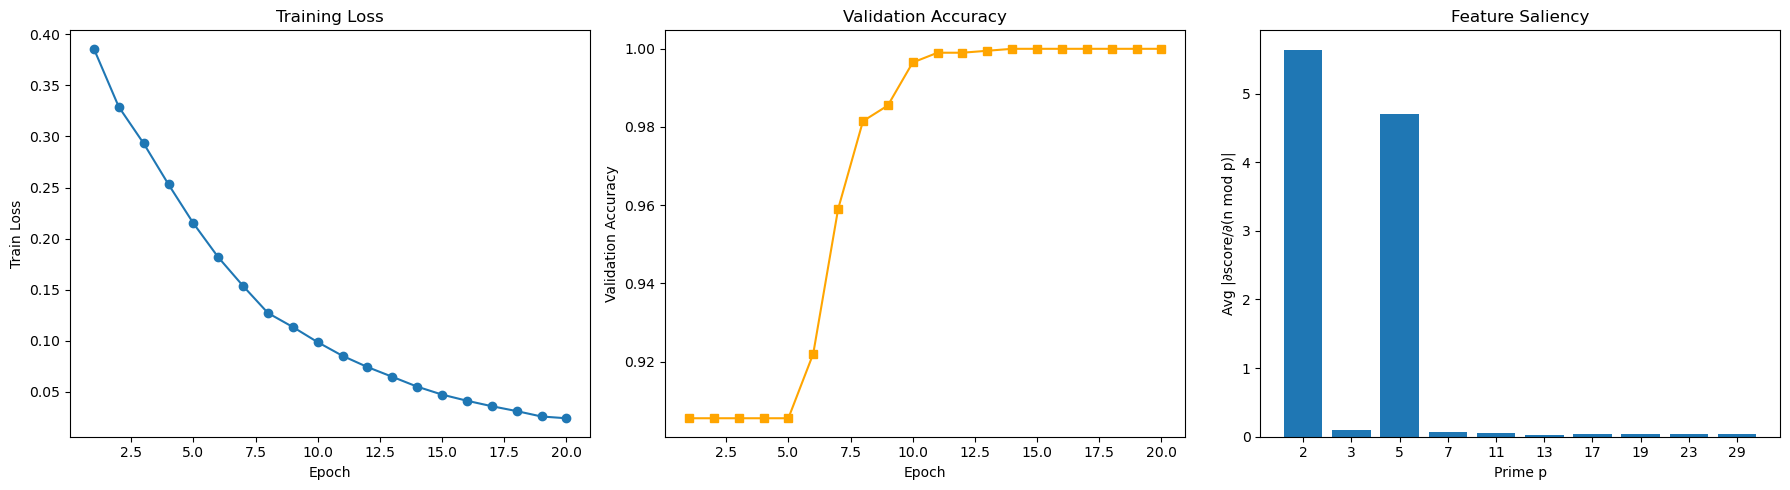

In [122]:
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
N = 10000
primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]  # first 10 primes
seq_len = len(primes)
batch_size = 128
epochs = 20
learning_rate = 1e-3
test_frac = 0.2
hidden_size = 32
# ────────────────────────────────────────────────────────────────────────────────

# ─── DATASET ────────────────────────────────────────────────────────────────────
X = np.zeros((N, seq_len), dtype=np.int64)
y = np.zeros(N, dtype=np.float32)
for i, n in enumerate(range(1, N + 1)):
    X[i, :] = [n % p for p in primes]
    y[i] = 1.0 if (n % 10 == 0) else 0.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=42, shuffle=True
)

def make_loader(X_np, y_np, shuffle=False):
    X_t = torch.from_numpy(X_np).float()           # (B, seq_len)
    y_t = torch.from_numpy(y_np).float().unsqueeze(1)  # (B,1)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, shuffle=True)
test_loader  = make_loader(X_test,  y_test,  shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── MODEL ──────────────────────────────────────────────────────────────────────
class EvenOddNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

model = EvenOddNN(input_dim=seq_len, hidden_dim=hidden_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ─── TRAINING WITH METRICS ──────────────────────────────────────────────────────
train_losses = []
val_accs     = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = (torch.sigmoid(model(xb)) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    val_accs.append(acc)

    #print(f"Epoch {epoch}/{epochs}  train_loss={avg_loss:.4f}  val_acc={acc:.4f}")

# ─── SALIENCY COMPUTATION ──────────────────────────────────────────────────────
model.eval()
saliency = torch.zeros(seq_len)
n_samples = 0
for xb, _ in train_loader:
    xb = xb.to(device)
    xb.requires_grad_()
    logits = model(xb)
    logits.sum().backward()
    grads = xb.grad.abs().sum(dim=0)  # (seq_len,)
    saliency += grads.cpu()
    n_samples += xb.size(0)
saliency /= n_samples

# ─── PLOT METRICS & SALIENCY ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training Loss
axes[0].plot(range(1, epochs+1), train_losses, marker='o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Training Loss")

# Validation Accuracy
axes[1].plot(range(1, epochs+1), val_accs, marker='s', color='orange')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Accuracy")
axes[1].set_title("Validation Accuracy")

# Saliency
axes[2].bar(range(seq_len), saliency.numpy())
axes[2].set_xticks(range(seq_len))
axes[2].set_xticklabels(primes)
axes[2].set_xlabel("Prime p")
axes[2].set_ylabel("Avg |∂score/∂(n mod p)|")
axes[2].set_title("Feature Saliency")

plt.tight_layout()
plt.show()

<span style="font-size: 200%;">Example 1: The prime number theorem</span>

We begin with the famous prime number theorem, which says that the prime counting function $$\pi(X) := \#\{p \leq X : p \text{ prime}\},$$ grows like $$\pi(X) \sim \frac{X}{\log(X)}.$$ This was originally conjectured by a teenage Gauss in 1792 or 1793, who made his conjecture based on tables of primes up to 3,000,000. We will first attempt to recreate Gauss's experiment using modern tools. 
<img
  src="images/gauss_table.png"
  width="500" height="250"
  style="display: block; margin-left: auto; margin-right: auto;"
  alt="Gauss table"
/>
We will generate primes up to 3,000,000 and attempt to do symbolic regression using a standard package (pysr). Here, we will make sure to include $\log(X)$ as one of the unary operations, and this will be the only human input. We show the machine only the primes in the range $10^6 \leq p \leq 3 \cdot 10^6$ since we are interested in an asymptotic formula.

Using features ['x']


=== Discovered formulas (loss vs complexity) ===
                                                                                     equation         loss  complexity
                                                                                    136975.58 1.624593e+09           1
                                                                              x * 0.074202836 9.526832e+06           3
                                                                 (x * 0.19588578) ^ 0.9249063 1.511453e+03           5
                                                                     x / (log(x) + -1.078857) 4.161832e+02           6
                                                    ((1.1709081 / log(x)) + -0.006239553) * x 3.531201e+02           8
                                      (x * (0.98852754 / (log(x) + -1.2433038))) + -111.87666 3.476936e+02          10
                         ((x * 0.98852694) / (log(x - -1.2840452) + -1.2433038)) + -111.82102 3.475826e+02          12

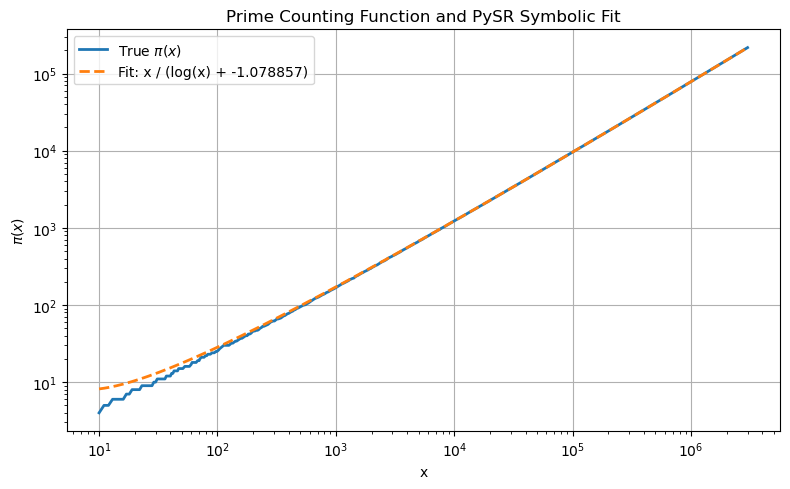

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import sympy
import matplotlib.pyplot as plt
from pysr import PySRRegressor

# -----------------------------------------------------------------------------
# 1) Generate data: π(x) on a log-spaced grid up to 3e6
# -----------------------------------------------------------------------------
X_max = 3_000_000
x_vals = np.unique(np.logspace(np.log10(10), np.log10(X_max), 500, dtype=int))
pi_vals = np.array([sympy.primepi(int(x)) for x in x_vals], dtype=float)

# Wrap in a DataFrame with a single column "x"
df = pd.DataFrame({"x": x_vals})

# -----------------------------------------------------------------------------
# 2) Configure PySR allowing /, log, pow, etc., with warnings suppressed
# -----------------------------------------------------------------------------
model = PySRRegressor(
    niterations=50,
    unary_operators=["log"],
    binary_operators=["+", "-", "*", "/", "pow"],
    extra_sympy_mappings={"pow": lambda x, y: x**y},
    loss="loss(x, y) = (x - y)^2",
    select_k_features=10,
    model_selection="best",
    maxsize=20,
    population_size=100,
    verbosity=0,  # turn off PySR info messages
)

# -----------------------------------------------------------------------------
# 3) Fit only in the asymptotic regime x ≥ 1e6
# -----------------------------------------------------------------------------
mask = df["x"] >= 1_000_000
model.fit(df[mask], pi_vals[mask])

# -----------------------------------------------------------------------------
# 4) Extract and print the discovered formulas
# -----------------------------------------------------------------------------
pareto = model.equations_
print("\n=== Discovered formulas (loss vs complexity) ===")
print(pareto[["equation", "loss", "complexity"]].to_string(index=False))

# Use get_best() to fetch the top formula
best = model.get_best()
best_eq = best["equation"]
print(f"\nBest formula: {best_eq}")

# -----------------------------------------------------------------------------
# 5) Predict over the full range and plot
# -----------------------------------------------------------------------------
y_pred = model.predict(df)

plt.figure(figsize=(8,5))
plt.plot(x_vals, pi_vals, label=r"True $\pi(x)$", linewidth=2)
plt.plot(x_vals, y_pred, "--", label=f"Fit: {best_eq}", linewidth=2)
plt.xlabel("x")
plt.ylabel(r"$\pi(x)$")
plt.xscale('log')
plt.yscale('log')
plt.title("Prime Counting Function and PySR Symbolic Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The symbolic regression predicts the correct asymptotic $\sim X/\log(X)$ but with an extra constant. In fact, this constant has a name: Legendre's constant. Based on tables of primes up $400,000$, Legendre conjuected in 1797 or 1798 that $$\pi(X) \sim \frac{X}{A \log X + B}$$ where $A,B$ are unspecified constants. In 1808 he estimated $A = 1$ and $B = −1.08366$. The machine also recognized this expression, as well as the constants $A = 1$ and $B = -1.07886$. We now know that the correct value is $B = -1$.
<img
  src="images/Klyve_LegendreCountPi.png"
  width="500" height="250"
  style="display: block; margin-left: auto; margin-right: auto;"
  alt="Legendre table"
/>

<span style="font-size: 200%;">Example 2: Extrapolating $\sum_{n \leq N} \lambda(n)$</span>

Having discovered the prime number theorem more or less automatically, we move on to a more subtle feature in the distribution of primes. The Liouville lambda function is defined by $$\lambda(n) = (-1)^{\Omega(n)}$$ where $\Omega(n)$ is the number of prime factors of $n$ counted with multiplicity. For our next experiment, we will consider the summatory function $$A(X) = \exp(-X/2) \sum_{n \leq \exp(X)} \lambda(n)$$ Instead of looking for a closed-form asymptotic, we will attempt to extrapolate this function numerically. We begin by generating data using an efficient algorithm from a paper of Borwein, Ferguson, and Mossinghoff:

Computed A(x) in 3757.30s using ~119497095 bytes of memory.


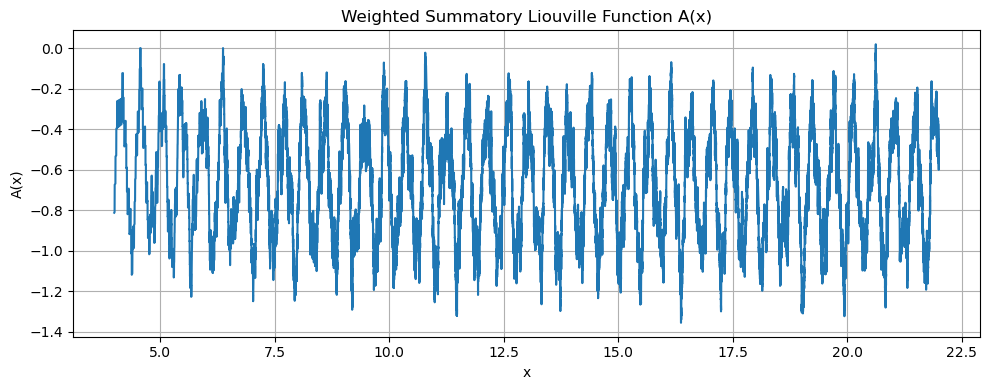

In [73]:
import numpy as np
import math
import time
import pickle
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Memory-efficient Liouville computation via segmented bit-sieve
# -----------------------------------------------------------------------------
# Residues mod 30 that are coprime to 30
residues = [1, 7, 11, 13, 17, 19, 23, 29]
# Map residue to bit mask within a byte (bit 7 down to bit 0)
residue_to_bit = {r: 1 << (7 - i) for i, r in enumerate(residues)}

def simple_primes_upto(n):
    """
    Sieve of Eratosthenes up to n, returns list of primes ≤ n.
    """
    sieve = bytearray(b"\x01") * (n + 1)
    sieve[0:2] = b"\x00\x00"
    for i in range(2, int(math.isqrt(n)) + 1):
        if sieve[i]:
            sieve[i*i:n+1:i] = b"\x00" * (((n - i*i) // i) + 1)
    return [i for i in range(2, n+1) if sieve[i]]


def build_liouville_bit_table(N):
    """
    Build a compressed bit-table for λ(n) using a segmented sieve.
    - Rounds N up to a multiple of 30 (call it M).
    - Allocates M/30 bytes, one byte per block of 30 integers.
    - Each byte has 8 bits for the 8 residues coprime to 30.
    Returns (table: bytearray, M: int).
    """
    # round up to nearest multiple of 30
    M = ((N + 29) // 30) * 30
    table_size = M // 30
    table = bytearray(table_size)
    # Initialize block 0: λ(1)=+1 (bit=0) and primes>1 in 1..29 have λ(p)=-1 (bit=1)
    table[0] = 0x7F       # bits for residues [7,11,13,17,19,23,29] set to 1
    # other blocks default to all bits=1 ⇒ λ(n)=-1 initially
    table[1:] = b"\xFF" * (table_size - 1)

    primes = simple_primes_upto(int(math.isqrt(M - 1)))
    a = 30
    while a < M:
        b = min(2*a - 1, M - 1)
        sqrt_b = int(math.isqrt(b))
        for p in primes:
            if p < 7:
                continue
            if p > sqrt_b:
                break
            # first multiple of p ≥ a
            start = ((a + p - 1) // p) * p
            for k in range(start, b + 1, p):
                r = k % 30
                if r not in residue_to_bit:
                    continue
                idx = k // 30
                bit = residue_to_bit[r]
                # factor out p: look at λ(k/p)15 : 00 ~ 16 : 00
                kp = k // p
                rkp = kp % 30
                if rkp not in residue_to_bit:
                    continue
                bitkp = residue_to_bit[rkp]
                beta = 1 if (table[kp // 30] & bitkp) else 0
                new_beta = 1 - beta
                if new_beta:
                    table[idx] |= bit
                else:
                    table[idx] &= ~bit
        a = b + 1
    return table, M


def get_lambda(n, table):
    """
    Recover λ(n) by extracting small factors 2,3,5 and then using the bit-table.
    """
    m = n
    cnt = 0
    for p in (2, 3, 5):
        while m % p == 0 and m > 0:
            m //= p
            cnt += 1
    if m == 1:
        lam_m = 1
    else:
        idx = m // 30
        r = m % 30
        bit = residue_to_bit.get(r, 0)
        beta = 1 if (table[idx] & bit) else 0
        lam_m = -1 if beta else 1
    lam_small = -1 if (cnt % 2) else 1
    return lam_m * lam_small


N_log = 22
N = int(math.floor(math.exp(N_log)))

start = time.perf_counter()
# 1) Build compressed bit-table
table, M = build_liouville_bit_table(N)

# 2) Prepare evaluation points
xs = np.linspace(4, N_log - 1/10000, 100000)
thresholds = np.floor(np.exp(xs)).astype(int)
sorted_idx = np.argsort(thresholds)

# 3) One-pass prefix-sum, recording A(x)
L_cur = 0
ys = np.empty_like(xs)
j = 0
for n in range(1, N + 1):
    L_cur += get_lambda(n, table)
    while j < len(xs) and thresholds[sorted_idx[j]] == n:
        i = sorted_idx[j]
        ys[i] = math.exp(-xs[i] / 2) * L_cur
        j += 1
    if j >= len(xs):
        break

end = time.perf_counter()
mem_bytes = len(table)
print(f"Computed A(x) in {end - start:.2f}s using ~{mem_bytes} bytes of memory.")

# 4) Plot the result
plt.figure(figsize=(10, 4))
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('A(x)')
plt.title('Weighted Summatory Liouville Function A(x)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Save results
with open('A_data.pkl', 'wb') as f:
    pickle.dump(list(zip(xs, ys)), f)

We want to see if we can learn any structure in $A(X)$. To do so, we will train an LSTM (long short-term memory) model, a specific type of RNN (recurrent neural network), to try to extrapolate the functions of interest. This type of model takes as input a fixed-length contiguous subsequence of the data and learns to predict the next value in the sequence. The basic idea of an RNN is to create a hidden state $h_0 \in \mathbb{R}^d$, learn a function $f$ that updates this hidden state $h_t := f(h_{t-1}, x_t)$ inductively using the input sequence $x_t$, and predict the output using a linear function of the final hidden state. An LSTM updates the hidden state in a more complicated way. By repeatedly predicting the next value, we can attempt to extrapolate the data. We try to interpret what the model learns by projecting the orbit of the hidden state to $\mathbb{R}^2$ using PCA (principal component analysis), which finds a projection of maximum variance. As an example, we first try to learn the periodic function $\sin(2 \pi x)$ and the almost perodic function $\sin(2 \pi x) + \sin (\sqrt{2} \pi x)$

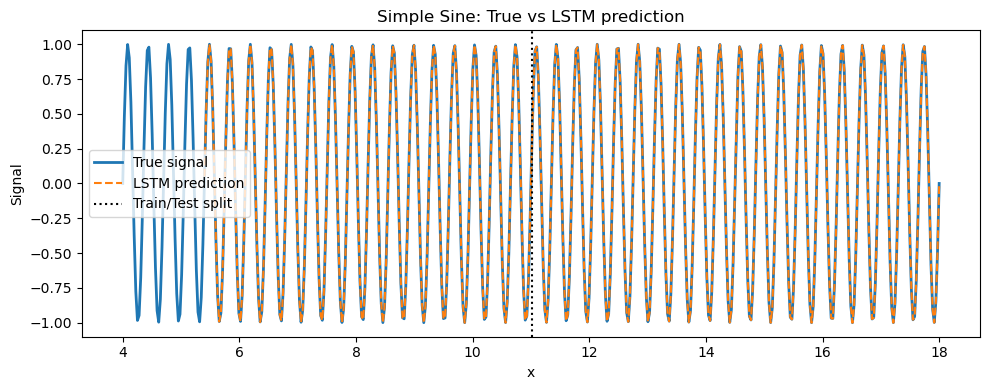

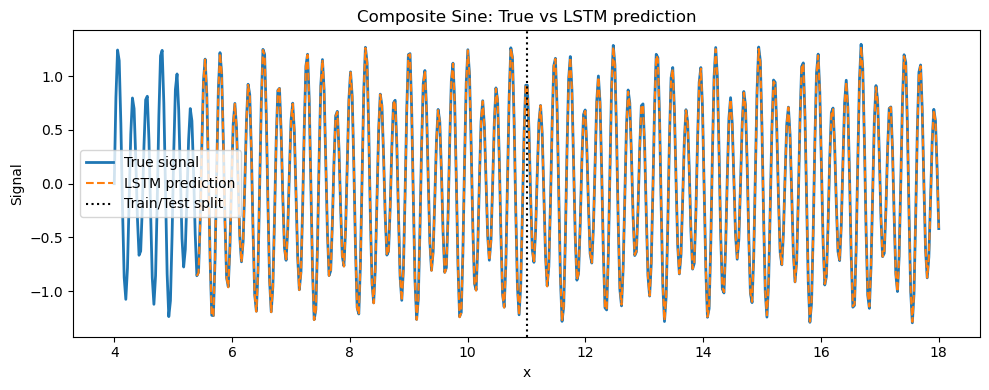

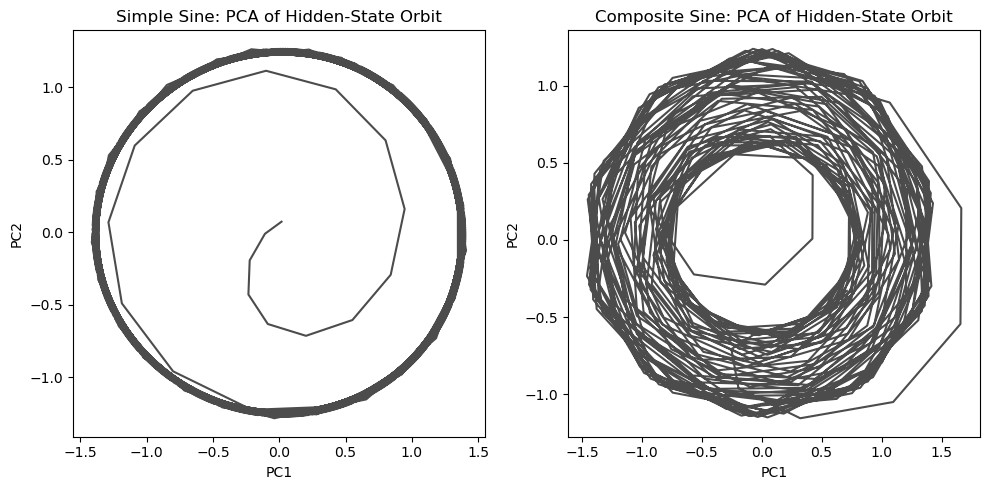

In [36]:
import warnings
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
np.random.seed(0)
torch.manual_seed(0)

# Experiment settings
n_points = 500
window = 50
split = n_points // 2
epochs = 500

# Signals to run: (name, generator function)
signals = [
    ("Simple Sine",
     lambda X: np.sin(2 * np.pi * 40 * (X - 4) / 14).astype(np.float32)),
    ("Composite Sine",
     lambda X: (np.sin(2 * np.pi * 40 * np.sqrt(2) * (X - 4) / 14) +
                0.3 * np.sin(2 * np.pi * 40 * (X - 4) / 14)).astype(np.float32))
]

# Define LSTM model
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).flatten()

# Storage for PCA trajectories
trajectories = []

# Prepare common X grid
X_all = np.linspace(4, 18, n_points).astype(np.float32)

# Loop over signals
for name, gen in signals:
    y_all = gen(X_all)
    y_train, y_test = y_all[:split], y_all[split:]

    # Prepare training sequences
    def make_sequences(y):
        Xs, ys = [], []
        for i in range(window, len(y)):
            Xs.append(y[i-window:i])
            ys.append(y[i])
        return np.stack(Xs), np.stack(ys)

    X_seq, y_seq = make_sequences(y_train)
    train_ds = TensorDataset(torch.from_numpy(X_seq).unsqueeze(-1),
                             torch.from_numpy(y_seq))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

    # Instantiate and train model
    model = LSTMForecaster()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Generate predictions
    with torch.no_grad():
        # In-sample
        train_preds = []
        for i in range(window, split):
            seq = torch.tensor(y_train[i-window:i], dtype=torch.float32)\
                       .unsqueeze(0).unsqueeze(-1)
            train_preds.append(model(seq).item())
        train_preds = np.array(train_preds)
        # Out-of-sample recursive
        test_preds = []
        history = list(y_train[-window:])
        for _ in range(len(y_test)):
            seq = torch.tensor(history[-window:], dtype=torch.float32)\
                       .unsqueeze(0).unsqueeze(-1)
            p = model(seq).item()
            test_preds.append(p)
            history.append(p)
        test_preds = np.array(test_preds)

    # Assemble full prediction vector
    y_pred = np.empty_like(y_all)
    y_pred[:window]       = np.nan
    y_pred[window:split]  = train_preds
    y_pred[split:]        = test_preds

    # Plot true vs. prediction
    plt.figure(figsize=(10, 4))
    plt.plot(X_all, y_all, label="True signal", linewidth=2)
    plt.plot(X_all, y_pred, '--', label="LSTM prediction")
    plt.axvline(X_all[split], linestyle=':', label="Train/Test split", color = 'black')
    plt.xlabel("x")
    plt.ylabel("Signal")
    plt.title(f"{name}: True vs LSTM prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Collect hidden states for PCA
    with torch.no_grad():
        y_tensor = torch.from_numpy(y_all.reshape(1, n_points, 1))
        out, _   = model.lstm(y_tensor)
        hs       = out.squeeze(0).cpu().numpy()

    pca  = PCA(n_components=2)
    hs2  = pca.fit_transform(hs)
    trajectories.append((name, hs2))

# Plot hidden-state PCA orbits side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, (name, hs2) in zip(axes, trajectories):
    ax.plot(hs2[:, 0], hs2[:, 1], '-k', alpha=0.7)
    ax.set_title(f"{name}: PCA of Hidden-State Orbit")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
plt.tight_layout()
plt.show()

By showing the LSTM a simple sine wave and a composite sine wave, it learns dynamics that approximate a circle and a torus respectively. Also note that by computing the average angular velocity of the projection, we have a way to estimate the period of our signal. Now let us show it $A(X)$ and see what it learns. 

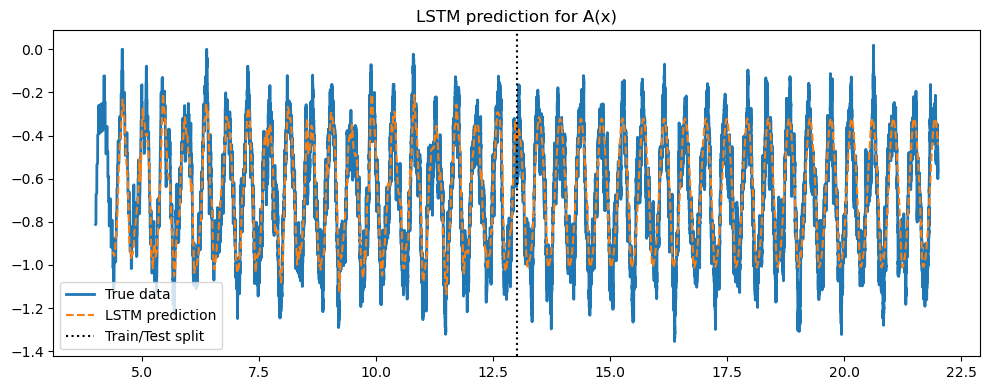

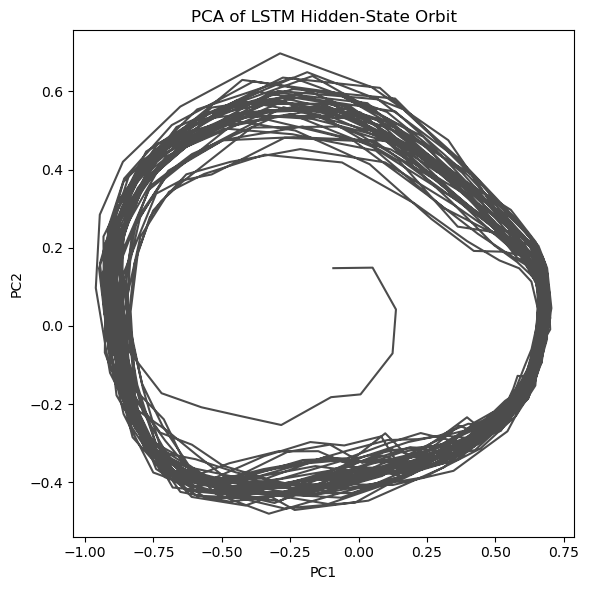

Test MSE on sampled test half: 1.4083e-02
Estimated frequency ≈ 14.114


In [1]:
import warnings
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
1459
warnings.filterwarnings("ignore")
np.random.seed(0)
torch.manual_seed(0)

# === PARAMETERS ===
N_sample = 1000   # set this to however many equally spaced samples you want
window   = 20     # sliding‐window length
epochs   = 500    # number of training epochs

# 1) Load & sort your full (x,y) data
with open('A_data.pkl','rb') as f:
    data = pickle.load(f)
arr      = np.array(data, dtype=float)
X_full   = arr[:,0].astype(np.float32)
y_full   = arr[:,1].astype(np.float32)
sort_idx = np.argsort(X_full)
X_full   = X_full[sort_idx]
y_full   = y_full[sort_idx]

# 2) Extract equally spaced subset of N_sample points
n_full = len(y_full)
idxs   = np.linspace(0, n_full - 1, N_sample).round().astype(int)
X_all  = X_full[idxs]
y_all  = y_full[idxs]

# 3) Split into train/test halves
n       = len(y_all)
split   = n // 2
y_train = y_all[:split]
y_test  = y_all[split:]

# 4) Build sliding‐window sequences on train half
def make_sequences(y, window):
    Xs, ys = [], []
    for i in range(window, len(y)):
        Xs.append(y[i-window:i])
        ys.append(y[i])
    return np.stack(Xs), np.stack(ys)

X_seq_train, y_seq_train = make_sequences(y_train, window)

# 5) Create DataLoader
train_ds     = TensorDataset(
    torch.from_numpy(X_seq_train).unsqueeze(-1),  # (batch, seq, 1)
    torch.from_numpy(y_seq_train)
)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# 6) Define LSTM forecaster
class LSTMForecaster(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=5, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)            # out: (batch, seq, hidden_dim)
        last   = out[:, -1, :]           # take last time‐step
        return self.fc(last).flatten()   # → (batch,)

model     = LSTMForecaster()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 7) Train
for ep in range(epochs):
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 8) In‐sample prediction on train half
train_preds = []
with torch.no_grad():
    for i in range(window, split):
        seq = torch.tensor(y_train[i-window:i], dtype=torch.float32)\
                   .unsqueeze(0).unsqueeze(-1)
        train_preds.append(model(seq).item())
train_preds = np.array(train_preds)

# 9) Recursive forecast on test half
test_preds = []
history    = list(y_train[-window:])
with torch.no_grad():
    for _ in range(len(y_test)):
        seq = torch.tensor(history[-window:], dtype=torch.float32)\
                   .unsqueeze(0).unsqueeze(-1)
        p = model(seq).item()
        test_preds.append(p)
        history.append(p)
test_preds = np.array(test_preds)

# 10) Assemble full prediction vector
y_pred = np.empty_like(y_all)
y_pred[:window]                          = np.nan
y_pred[window:split]                     = train_preds
y_pred[split:split + len(test_preds)]    = test_preds

# 11) Plot True vs. Predicted
plt.figure(figsize=(10,4))
plt.plot(X_full, y_full,      label="True data", linewidth=2)
plt.plot(X_all, y_pred, '--', label="LSTM prediction")
plt.axvline(X_all[split], color='k', linestyle=':', label="Train/Test split")
plt.title("LSTM prediction for A(x)")
plt.legend()
plt.tight_layout()
plt.show()

# 12) Extract hidden‐state trajectory and do PCA on the sampled sequence
with torch.no_grad():
    y_tensor = torch.from_numpy(y_all.reshape(1, n, 1))
    out, _   = model.lstm(y_tensor)           # out: (1, n, hidden_dim)
    hs       = out.squeeze(0).cpu().numpy()   # (n, hidden_dim)

pca = PCA(n_components=2)
hs2 = pca.fit_transform(hs)

# 13) Simple 2D line plot of the PCA orbit
plt.figure(figsize=(6,6))
plt.plot(hs2[:,0], hs2[:,1], '-k', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of LSTM Hidden‐State Orbit")
plt.tight_layout()
plt.show()

# 14) Print test MSE on the sampled test half
mse_test = mean_squared_error(y_test, test_preds)
print(f"Test MSE on sampled test half: {mse_test:.4e}")

# 15) Print estimated zeta zero
theta      = np.arctan2(hs2[split:,1], hs2[split:,0])
theta_un   = np.unwrap(theta)
dtheta     = np.diff(theta_un)
mean_dtheta= np.mean(dtheta)
dx         = X_all[1] - X_all[0]
omega      = mean_dtheta / dx
freq       = omega / (2 * np.pi)
print(f"Estimated frequency ≈ {2 * np.pi * abs(freq):.3f}")

The number 14.1 was first computed (but not published) by Riemann. The first non-trivial zero of the Riemman zeta function is $$\rho_1 = 0.5 + 14.135i.$$
By showing an LSTM nothing but $A(X)$, data coming from the parity of the number of prime factors, it learned dynamics that estimate the first zeta zero. Of course, the function $A(X)$ was carefully chosen. It was known to Ingham in 1942 that one can get a smooth approximation to $A(X)$ with the function $$A_m^*(X) = \frac{1}{\zeta(1/2)} + 2\Re\left( \sum_{0 < \gamma_n < m}\left(1 - \frac{\gamma_n}{m}\right) \frac{\zeta(2\rho_n)}{\rho_n\zeta'(\rho_n)}e^{i \gamma_n X}\right),$$ where $\rho_n = \frac{1}{2} + \gamma_n i$ runs over the non-trivial zeros of $\zeta$. Still, nowhere in our data do we have explicit information about the Riemman zeta function, nor did we select a model to search for periodic behavior. Asking an LSTM to extrapolate $A(X)$ automatically led to the zeta zeros. 

<span style="font-size: 200%;">Example 3: The BSD conjecture</span>

Let us now try to reproduce the discovery of the Birch and Swinnerton-Dyer conjecture. We recall that an elliptic curve $E/\mathbb{Q}$ is a smooth projective curve of genus 1 with at least one $\mathbb{Q}$-point, and these always have an affine model of the form $$E : y^2 = x^3 + Ax + B.$$ Mordell proved in 1922 that for an elliptic curve $E/\mathbb{Q}$ we have global structure $$E(\mathbb{Q}) \cong E(\mathbb{Q})_\text{tors} \oplus \mathbb{Z}^{r_E}.$$ Experimenting on ESDAC II, an early vacuum tube computer, Birch and Swinnerton-Dyer made the following observations in 1958:

<img
  src="images/BSD.png"
  width="800" height="400"
  style="display: block; margin-left: auto; margin-right: auto;"
  alt="BSD"
/>

In 2020, He, Lee, and Oliver were exploring the utility of machine learning in predicting invariants of elliptic curves. They observed that a simple logistic regression model could be trained to predict rank $r_E$ from the Frobenius traces $$a_p(E) = p + 1 - N_p.$$ We recreate their experiment here, and we show that their models had implicitly learned to approximate the BSD conjecture. For data, we follow HLO's experiment and sample 17,000 curves of rank 0 and 17,000 curves of rank 1 with conductor in $[20,000, 30,000]$ from the LMFDB (https://www.lmfdb.org/). Note that ordering elliptic curves by conductor is a challenging problem, and part of the reason why the following experiments are so successful.

Loading X, y from 'elliptic_XY.pkl'
Train accuracy: 0.9804044117647058
Test  accuracy: 0.9685294117647059


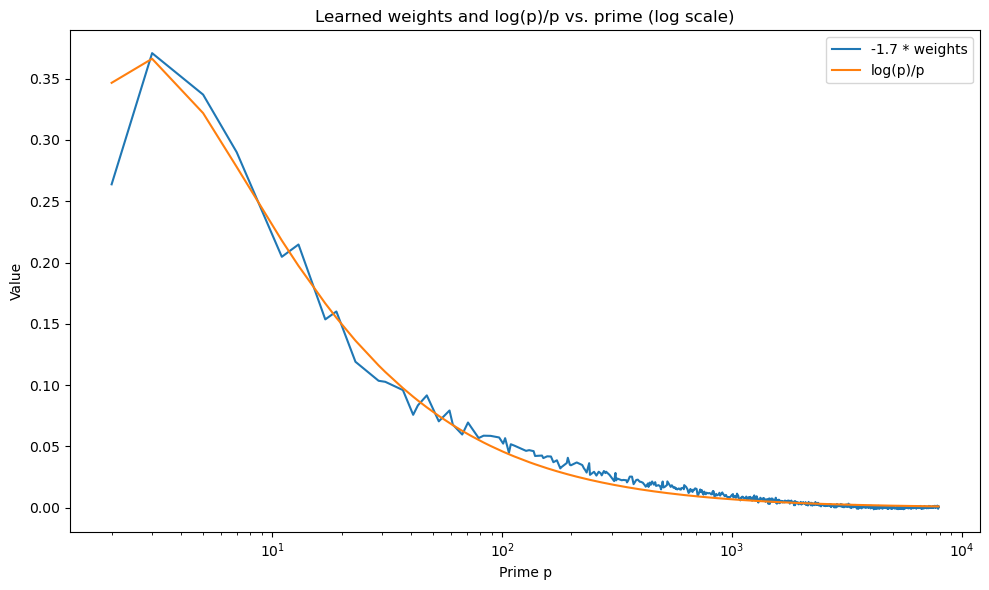

In [118]:
from lmf import db
from sage.all import EllipticCurve, prime_range
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# --------------------------------------------------------------------
# 1) Import data from LMFDB
# --------------------------------------------------------------------
ecq = db.ec_curvedata
COLS_TO_GET = ['ainvs', 'conductor', 'rank']
# Query for curves of rank 0 or 1 with conductors in (20000, 30000)
my_query = {'conductor': {'$lt': 30000, '$gt': 20000}, 'rank': {'$in': [0, 1]}}
my_curves = list(ecq.search(my_query, projection=COLS_TO_GET, one_per=['lmfdb_iso']))

# --------------------------------------------------------------------
# 2) Settings and fix random seeds
# --------------------------------------------------------------------
n_per_class = 17000       # number of curves per rank class
random_state = 42         # for reproducibility
random.seed(random_state)
np.random.seed(random_state)

# --------------------------------------------------------------------
# 3) Filter and sample curves by rank
# --------------------------------------------------------------------
rank0_curves = [c for c in my_curves if c['rank'] == 0]
rank1_curves = [c for c in my_curves if c['rank'] == 1]
assert len(rank0_curves) >= n_per_class, f"Not enough rank 0 curves: {len(rank0_curves)} found"
assert len(rank1_curves) >= n_per_class, f"Not enough rank 1 curves: {len(rank1_curves)} found"

sampled_rank0 = random.sample(rank0_curves, n_per_class)
sampled_rank1 = random.sample(rank1_curves, n_per_class)
# Combine and shuffle
sampled_curves = sampled_rank0 + sampled_rank1
random.shuffle(sampled_curves)

# --------------------------------------------------------------------
# 4) List of primes up to the 1000th prime (7919)
# --------------------------------------------------------------------
primes = list(prime_range(7920))

# --------------------------------------------------------------------
# 5) Load or build feature matrix X and label vector y
# --------------------------------------------------------------------
data_file = 'elliptic_XY.pkl'
if os.path.exists(data_file):
    print(f"Loading X, y from '{data_file}'")
    with open(data_file, 'rb') as f:
        X, y = pickle.load(f)
else:
    print("Sampling curves and computing X, y from scratch…")
    X_list, y_list = [], []
    for c in sampled_curves:
        E = EllipticCurve(c['ainvs'])
        ap_list = E.aplist(primes[-1])
        X_list.append(ap_list)
        y_list.append(c['rank'])
    X = np.array(X_list, dtype=float)
    y = np.array(y_list, dtype=int)
    with open(data_file, 'wb') as f:
        pickle.dump((X, y), f)
    print(f"Saved X, y to '{data_file}'")

# --------------------------------------------------------------------
# 6) Train-test split
# --------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# --------------------------------------------------------------------
# 7) Fit logistic regression
# --------------------------------------------------------------------
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)
clf.fit(X_train, y_train)

# --------------------------------------------------------------------
# 8) Evaluate
# --------------------------------------------------------------------
print("Train accuracy:", clf.score(X_train, y_train))
print("Test  accuracy:", clf.score(X_test, y_test))

# --------------------------------------------------------------------
# 9) Plot:
#    - Left: all class weights vs. primes (log x-axis)
#    - Right: Weights & log(p)/p vs. primes (log x-axis)
# --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
# Plot learned weights (binary classifier has a single coef_ array)
weights = clf.coef_[0]
ax.plot(primes, -1.7*weights, label="-1.7 * weights")
# Plot 1/p for comparison
ax.plot(primes, np.log(primes)/np.array(primes), label="log(p)/p")
ax.set_xscale('log')
ax.set_xlabel("Prime p")
ax.set_ylabel("Value")
ax.set_title("Learned weights and log(p)/p vs. prime (log scale)")
ax.legend()
plt.tight_layout()
plt.show()

Logistic regression assigns probabilties to classes via $$\mathbb{P}(y_i = 1) = \sigma(w \cdot x_i + b),$$
so we can see most of what the logistic regression model learned in the weights $w$. Plotting $-1.7 \times$ these weights shows that they are roughly a constant times $\log(p)/p$. On the other hand, the original BSD conjecture stated above is equivalent to the statement that $$\sum_{\substack{p \leq X \\ p \nmid \Delta_E}} \frac{a_p \log(p)}{p} = -r \log X + O(1).$$ Thus a logistic regression model learns to predict rank using $a_p$, and it does so in a manner equivalent to what Birch and Swinnerton-Dyer discovered. We asked the machine to find a local-to-global heuristic for elliptic curves, and it found the major conjecture in this direction.

<span style="font-size: 200%;">Example 4: Murmurations of elliptic curves</span>

Now let's see if there is any other structure in our data. A simple first experiment is dimensionality reduction via PCA. We continue with our same dataset of elliptic curves and project the point cloud of $a_p(E)$ vectors to $\mathbb{R}^2$:

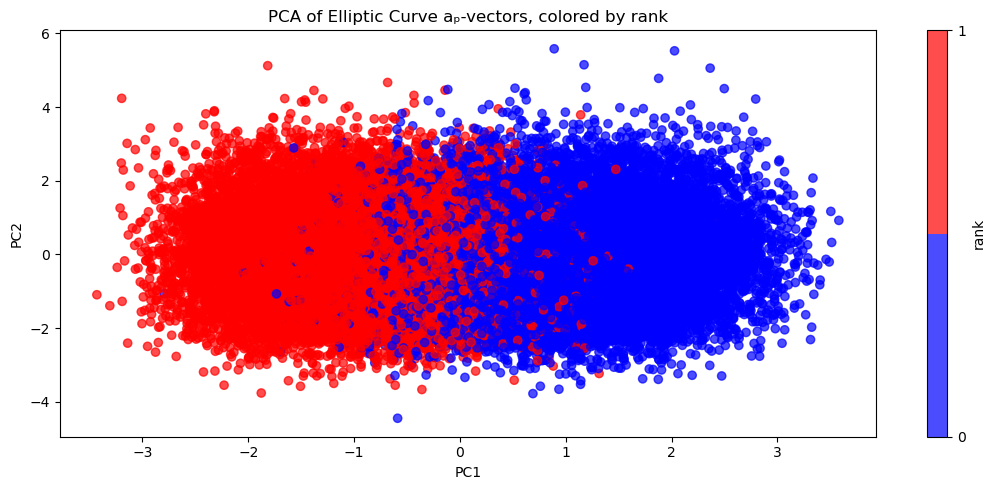

In [103]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --------------------------------------------------------------------
# 6’) Perform PCA on the full feature matrix X
# --------------------------------------------------------------------
pca = PCA(n_components=2, random_state=random_state)
X_0 = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_pca = pca.fit_transform(X_0)

# create a 2‐color map: index 0→blue, 1→red
cmap = ListedColormap(['blue', 'red'])

# --------------------------------------------------------------------
# 7’) Plot the first two principal components, colored by rank y
# --------------------------------------------------------------------
plt.figure(figsize=(11,5))
scatter = plt.scatter(
    X_pca[:, 0],         # PC1
    X_pca[:, 1],         # PC2
    c=y,                 # 0 or 1
    cmap=cmap,           # blue/red mapping
    vmin=0, vmax=1,      # ensure colors map exactly to 0 and 1
    alpha=0.7            # semi‐transparent for overplotting
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Elliptic Curve aₚ-vectors, colored by rank")
# show only 0 and 1 ticks on the colorbar
cbar = plt.colorbar(scatter, ticks=[0, 1], label="rank")
cbar.ax.set_yticklabels(['0', '1'])
plt.tight_layout()
plt.show()

We see that there is a clear separation between the rank 0 and the rank 1 curves in feature space. This should not be surprising since a simple model like logistic regression was able to distinguish rank. The next question is, along which axis do we have this separation? Plotting the weights in the first principal component reveals the following oscillation:

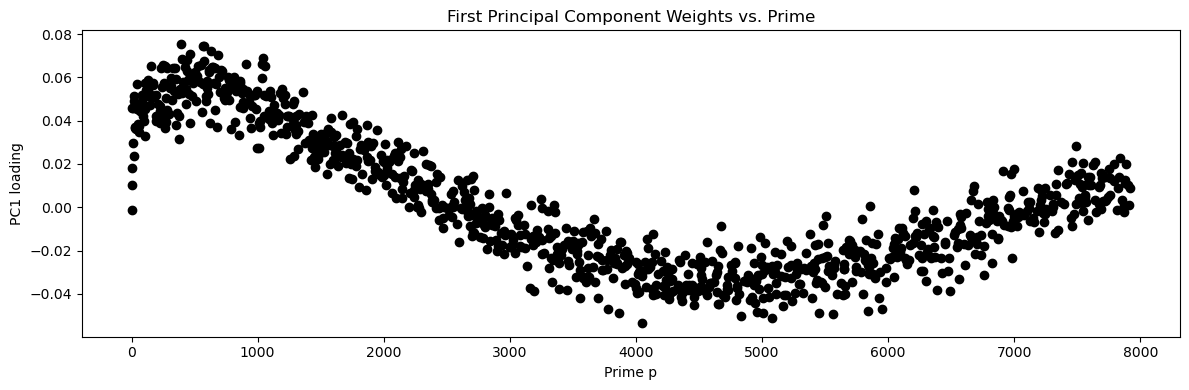

In [116]:
plt.figure(figsize=(12,4))
plt.scatter(
    primes,                   # x-axis: each prime
    pca.components_[0],       # y-axis: PC1 loading for that prime
    color='black'             # all in black
)
plt.xlabel("Prime p")
plt.ylabel("PC1 loading")
plt.title("First Principal Component Weights vs. Prime")
plt.tight_layout()
plt.show()

This suggests that the mean of rank 0 and the mean of rank 1 curves exhibit such a pattern. Below we compute $$\frac{1}{\#\mathcal{E}} \sum_{E \in \mathcal{E}} w_E a_p(E)$$ where $w_E = (-1)^{r_E}$ is the root number of $E$, revealing structure in this correlation function. 

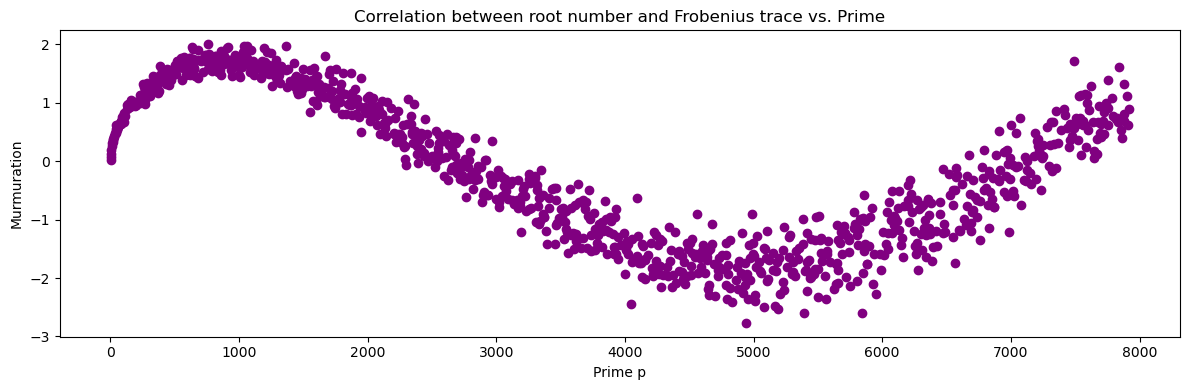

In [115]:
murm = sum([(-1)**y[i] * X[i] for i in range(len(y))])/len(y)
plt.figure(figsize=(12,4))
plt.scatter(primes, murm, color = 'purple')
plt.xlabel("Prime p")
plt.ylabel("Murmuration")
plt.title("Correlation between root number and Frobenius trace vs. Prime")
plt.tight_layout()
plt.show()

This was first observed in 2022 in this manner, and is now known as a murmuration of elliptic curves. Since this original observation, similar patterns have been found in many different arithmetic contexts, and several new theorems have been proven regarding these correlation functions. This was a genuine machine learning discovery in number theory! See https://math.mit.edu/~drew/murmurations.html for many more examples of murmurations. 

<span style="font-size: 200%;">Example 5: Learning the root number</span>

The existence of an unexpected correlation between root numbers and Frobenius traces led Sarnak to pose the following question:
<img
  src="images/sarnak_question.png"
  width="800" height="400"
  style="display: block; margin-left: auto; margin-right: auto;"
  alt="BSD"
/>
More precisely, we would like to understand if statistical correlations between $a_p(E)$ and $w_E$ are strong enough to allow us to predict $w_E$ with greater than $50%$ accuracy in polynomial time as $N_E \to \infty$. Current algebraic methods for computing the root number require factoring the conductor, which prevents polynomial-time computation. Analytic methods using the approximate functional equation require computing $a_p(E)$ for primes up to $O(N_E^{1/2 + o(1)})$, also preventing polynomial time computation. On the other hand, by a theorem of Serre, GRH for Artin L-functions implies that primes up to just $O(\log(N_E)^2)$ are enough to uniquely determine $w_E$. We now attempt to train deep convolutional neural networks to predict $w_E$ using just primes up to $\log(N_E)^3$. Since we need to take $N_E \to \infty$, the LMFDB will not suffice. Instead, we use the following algorithm due to Sutherland to sample elliptic curves with large conductor:

In [44]:
import os
import pickle
from sage.all import EllipticCurve, factor, prime_range
import random, math
import numpy as np

# ─── USER PARAMETERS ───────────────────────────────────────────────────────────
n           = 10            # conductor‐range [10^n, 10^n + 10^(n-1)]
num_curves  = 24000         # how many distinct isogeny‐classes to collect
# ────────────────────────────────────────────────────────────────────────────────

# where to cache your data
DATA_FILE = f"elliptic_data_n{n}.pkl"

if os.path.exists(DATA_FILE):
    print(f"Loading cached data from {DATA_FILE!r}…")
    with open(DATA_FILE, "rb") as f:
        X, y, primes = pickle.load(f)
    k = X.shape[1]
    print(f"  → Loaded X.shape = {X.shape}, y.shape = {y.shape}, #primes = {k}")
else:
    print("No cached data found; sampling now…")

    # 1) conductor‐window
    Nmin = 10**n
    Nmax = Nmin + 10**(n-1)

    # 2) prime‐bound: Pmax = floor((log 10^n)^3)
    Pmax   = int(math.log(10**n)**3)
    primes = list(prime_range(Pmax + 1))
    k      = len(primes)

    # 3) for aplist
    max_p = primes[-1]

    # 4) squarefree check
    def is_squarefree(D):
        return all(e == 1 for (_, e) in factor(D))

    # 5) sample with isogeny‐class filtering
    curves       = []
    seen_iso_cls = set()

    while len(curves) < num_curves:
        # pick A
        A = random.randint(1, int((Nmax/64)**(1/3)))

        # Δ‐window gives B‐bounds
        δ_low  = Nmin  - 64*A**3
        δ_high = Nmax  - 64*A**3
        if δ_high <= 0:
            continue

        B_low  = math.ceil(math.sqrt(max(δ_low, 0)/432))
        B_high = math.floor(math.sqrt(δ_high   /432))
        if B_low % 2 == 0:
            B_low += 1
        if B_low > B_high:
            continue

        B = random.randrange(B_low, B_high+1, 2)

        # square‐free check
        D = 4*A**3 + 27*B**2
        if not is_squarefree(D):
            continue

        # test conductor
        E = EllipticCurve([0,0,0,A,B])
        c = E.conductor()
        if not (Nmin <= c <= Nmax):
            continue

        # isogeny‐class filtering
        iso = E.isogeny_class()
        if iso in seen_iso_cls:
            continue

        seen_iso_cls.add(iso)
        curves.append(E)

    print(f"Collected {len(curves)} distinct isogeny‐classes; Pmax = {Pmax}, #primes = {k}")

    # 6) build X via aplist, and y via root_number()
    X = np.zeros((len(curves), k), dtype=int)
    y = np.zeros(len(curves),     dtype=int)

    for i, E in enumerate(curves):
        X[i, :] = E.aplist(max_p)
        y[i]   = E.root_number()    # ±1

    print(f"X.shape = {X.shape}")
    print(f"y.shape = {y.shape},  root number counts: {np.bincount((y+1)//2)}")

    # 7) save for next time
    with open(DATA_FILE, "wb") as f:
        pickle.dump((X, y, primes), f)
    print(f"Saved data to {DATA_FILE!r}")

No cached data found; sampling now…
Collected 24000 distinct isogeny‐classes; Pmax = 12208, #primes = 1459
X.shape = (24000, 1459)
y.shape = (24000,),  root number counts: [12102 11898]
Saved data to 'elliptic_data_n10.pkl'


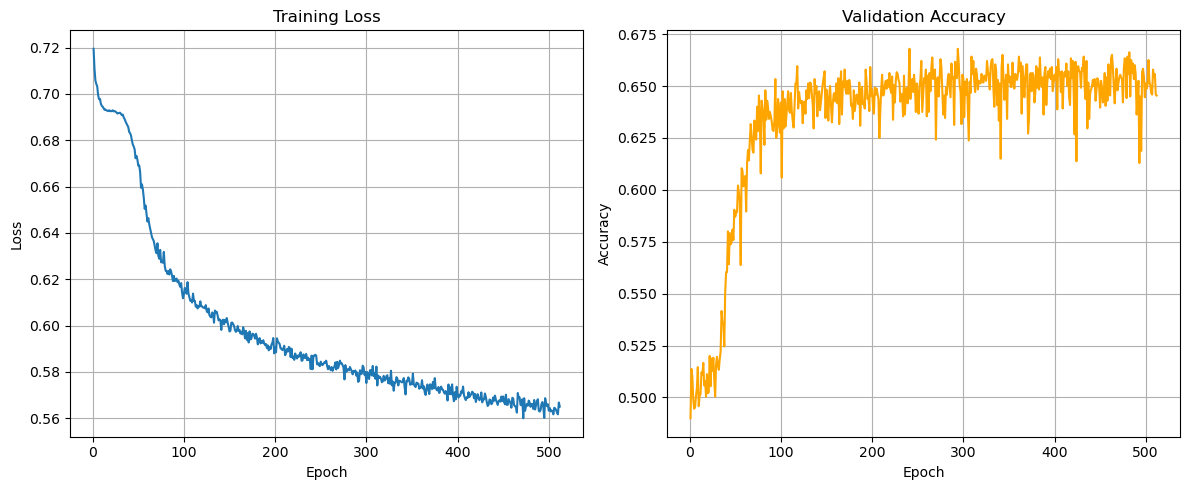

In [75]:
import os
import random
import numpy as np
import torch

# ─── FIX RANDOM SEEDS FOR REPRODUCIBILITY ───────────────────────────────────────
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
# ────────────────────────────────────────────────────────────────────────────────

import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# ─── HYPERPARAMETERS ────────────────────────────────────────────────────────────
filters           = 16      
kernel_size       = 13      
pool_size         = 16      
dropout_rate      = 0.2     
conv_blocks_half  = 5       
conv_blocks_same  = 3       
learning_rate     = 1e-3    
batch_size        = 64
epochs            = 512
test_frac         = 0.10
verbose           = False   # set to False to disable epoch prints
# ────────────────────────────────────────────────────────────────────────────────

# ─── LOAD / PREP DATA ───────────────────────────────────────────────────────────
# Assume X (N, k) and y (N,) in {-1,+1} already in memory
# Convert to class‐indices 0/1
y_idx = ((y + 1)//2).astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_idx, test_size=test_frac, shuffle=True, random_state=SEED
)

def make_loader(X_np, y_np, shuffle=False):
    X_t = torch.from_numpy(X_np).float().unsqueeze(1)  # (B,1,k)
    y_t = torch.from_numpy(y_np).long()                # (B,)
    ds  = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, shuffle=True)
test_loader  = make_loader(X_test,  y_test,  shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── MODEL ──────────────────────────────────────────────────────────────────────
class RootNumberCNN(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        layers = []
        in_ch = 1

        for _ in range(conv_blocks_half):
            layers += [
                nn.Conv1d(in_ch, filters, kernel_size,
                          stride=2, padding=kernel_size//2),
                nn.ReLU(),
                nn.AvgPool1d(pool_size,
                             stride=1,
                             padding=(pool_size-1)//2),
                nn.BatchNorm1d(filters),
                nn.Dropout(dropout_rate),
            ]
            in_ch = filters

        for _ in range(conv_blocks_same):
            layers += [
                nn.Conv1d(in_ch, filters, kernel_size,
                          stride=1, padding=kernel_size//2),
                nn.ReLU(),
                nn.AvgPool1d(pool_size,
                             stride=1,
                             padding=(pool_size-1)//2),
                nn.BatchNorm1d(filters),
                nn.Dropout(dropout_rate),
            ]

        self.features = nn.Sequential(*layers)
        with torch.no_grad():
            dummy = torch.zeros(1, 1, seq_len)
            feat  = self.features(dummy)
            flat_dim = feat.numel()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = RootNumberCNN(seq_len=X.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ─── TRAIN & EVALUATE ──────────────────────────────────────────────────────────
train_losses = []
val_accs     = []

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    acc = correct / total
    val_accs.append(acc)

    if verbose:
        print(f"Epoch {epoch:3d}/{epochs}  loss={avg_loss:.4f}  val_acc={acc:.4f}")

# ─── PLOT METRICS ───────────────────────────────────────────────────────────────
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='train loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), val_accs, label='val acc', color='orange')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

It seems that we can still learn something at $N_E \approx 10^{10}$, although the model struggles to obtain high accuracy. If we continue to experiment with larger $N_E$, we will observe that the performance continues to drop. This is evidence that, despite Serre's theorem, there is no "low-complexity" function that can determine the root number from primes up to $O(\log(N_E)^2)$.